# Surgical Tool Segmentation: Model Training

This notebook implements a solution for the semantic segmentation of surgical tools from the SAR-RARP50 dataset. Semantic segmentation is a computer vision task that involves labelling every pixel in an image with a corresponding class.

**Objective:** Generate pixel-level masks for RGB frames of surgical videos, segmenting both prominent surgical tools as well as thin and small objects such as surgical clips, suturing threads and needles.

## 1. Environment Setup

This section prepares the environment. The notebook is designed to be run in Google Colab, but can be adapted to be run locally.

The following code will:

1. **Clone the Project Repository:** Pulls the necessary files and project structure from GitHub.

2. **Install Dependencies:** Installs all required Python libraries from the requirements.txt file.

*If you are running this notebook locally, you have likely already cloned the GitHub repository. The main setup step is to install the required Python libraries.*

In [ ]:
# Folder location of the cloned or to-be-cloned repository
PROJECT_DIR = "Surgical-Segmentation-Challenge"

# --- COMMENT OUT IF RUNNING LOCALLY ---
# This section is for setting up the environment in Google Colab
%cd "/content"
repo_url = "https://github.com/isi22/Surgical-Segmentation-Challenge.git"
!git clone "{repo_url}" "{PROJECT_DIR}"
# from google.colab import drive
# drive.mount('/content/drive')
# --- END COMMENT OUT ---

# Change the current working directory to the project root
%cd "{PROJECT_DIR}"

# Install all required packages
print("\nInstalling dependencies from requirements.txt...")
!pip install -q -r requirements.txt

print("\n Environment setup complete. Current directory:")
!pwd

/content
Cloning into 'Surgical-Segmentation-Challenge'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 45 (delta 23), reused 17 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 35.45 KiB | 17.72 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Mounted at /content/drive
/content/Surgical-Segmentation-Challenge

Installing dependencies from requirements.txt...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.2 MB/s eta 0:00:00

 Environment setup complete. Current directory:
/content/Surgical-Segmentation-Challenge


## 2. Import Libraries

In [2]:
import glob
import os
import random
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import load_model

import albumentations as A

## 3. Configuration

In [ ]:
# --- Training Hyperparameters ---
VAL_SPLIT = 0.2
BATCH_SIZE = 8
SEED = 42
IMG_ROWS, IMG_COLS = 480, 640

# --- Path Definitions ---
DATA_DIR = 'data'
MODEL_DIR = 'models'
# MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/models'
TRAIN_PATH = os.path.join(DATA_DIR, 'train_dataset')
TEST_PATH = os.path.join(DATA_DIR, 'test_dataset')
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'unet_efficientnetb4_best.keras')
HISTORY_SAVE_PATH = os.path.join(MODEL_DIR, 'live_training_history.csv')

# --- Model & Class Definitions ---
input_shape = (IMG_ROWS, IMG_COLS, 3)
class_names = [
    "Background", "Tool clasper", "Tool wrist", "Tool shaft",
    "Suturing needle", "Thread", "Suction tool", "Needle holder",
    "Clamps", "Catheter"
]
NUM_CLASSES = len(class_names)

## 4. Data Setup

This section handles the download of the SAR-RARP50 dataset.

The train and test data is stored as two pre-processed `.zip` files on Google Drive. The zip files were generated by the `1_data_preprocessing.ipynb` notebook, which handled the following pre-processing:
 - downloaded and unzipped the original archives
 - extracted images from the surgical videos that match the segmentation masks
 - consolidated all images and masks into flat `all_rgb` and `all_segmentation` directories

### Download the Data

**When using Google Colab:**

When using Google Colab, the data needs to be re-downloaded every time a new virtual machine is used. The following cell automatically downloads the pre-processed data from the public Google Drive links.

In [ ]:
%%time

# Create the data directory
os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(TRAIN_PATH) or not os.path.exists(TEST_PATH):
    print("Data not found. Starting download and unzipping process...")

    # Publicly shared Google Drive file IDs for the zip files
    train_id = "1qqJbuOcBWa64oqNCRNNrz5663zhv1kVK"
    test_id = "1px81XhKGojwhSLVQTYUOeru5MWBoKzEO"

    print("Downloading train.zip...")
    !gdown --id {train_id} -O data/train_dataset.zip

    print("\nDownloading test.zip...")
    !gdown --id {test_id} -O data/test_dataset.zip

    # Unzip the files into the structured folders
    print("\nUnzipping data...")
    !unzip -q data/train_dataset.zip -d {TRAIN_PATH}
    !unzip -q data/test_dataset.zip -d {TEST_PATH}

    # Clean up the zip files
    !rm data/train_dataset.zip data/test_dataset.zip

    print("\n Data download complete.")
else:
    print("Data already downloaded.")

In [ ]:
# %%time

# # Create the data directories
# os.makedirs(TRAIN_PATH, exist_ok=True)
# os.makedirs(TEST_PATH, exist_ok=True)

# if not os.path.exists(os.path.join(TRAIN_PATH, 'all_rgb')) or not os.path.exists(os.path.join(TEST_PATH, 'all_rgb')):
#   print("Copying train_dataset.zip...")
#   !cp "/content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/train_dataset.zip" "data/"
#   print("\nCopying test_dataset.zip...")
#   !cp "/content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/test_dataset.zip" "data/"

#   #Unzip the files into the structured folders
#   print("\nUnzipping data...")
#   !unzip -q data/train_dataset.zip -d {TRAIN_PATH}
#   !unzip -q data/test_dataset.zip -d {TEST_PATH}

#   # Clean up the zip files
#   !rm data/train_dataset.zip data/test_dataset.zip

#   print("\n Data copy complete.")
# else:
#     print("Data already copied.")

Copying train_dataset.zip...

Copying test_dataset.zip...

Unzipping data...

 Data copy complete.
CPU times: user 1.01 s, sys: 125 ms, total: 1.14 s
Wall time: 10min 44s


**When running the notebook locally:**

1. **Create the `data` Directory:** inside the `Surgical-Segmentation-Challenge` project folder, create a new folder named `data`.

2. **Download the Zip Files:** download the two pre-processed zip files:

   - Train Set: https://drive.google.com/file/d/1qqJbuOcBWa64oqNCRNNrz5663zhv1kVK/view?usp=drive_link

   - Test Set: https://drive.google.com/file/d/1px81XhKGojwhSLVQTYUOeru5MWBoKzEO/view?usp=drive_link

3. **Unzip the Data:** place the downloaded `train_dataset.zip` and `test_dataset.zip` files inside the data folder and unzip them.

The final directory structure should look like this:

```
Surgical-Segmentation-Challenge/
└── data/
    └── train_dataset
        └── all_segmentation
        └── all_rgb
    └── test_dataset
        └── all_segmentation
        └── all_rgb
```

### Inspect the Data

The dataset is already divided into train data (13043 frames from 40 videos, 80%) and test data (3252 from 10 videos, 20%). It has been sorted into the following directory structure, where the `all_rgb` folder contains the to-be-segmented images and the `all_segmentation` folder contains the ground-truth segmentation masks from all videos. From each of the 50 video segments, there are between 101 and 706 extracted frames available.



In [6]:
# Define folder locations
all_train_rgb_path = os.path.join(TRAIN_PATH, 'all_rgb')
all_train_seg_path = os.path.join(TRAIN_PATH, 'all_segmentation')
all_test_rgb_path = os.path.join(TEST_PATH, 'all_rgb')
all_test_seg_path = os.path.join(TEST_PATH, 'all_segmentation')

# Function to get paths and verify files
def get_and_verify_paths(dataset_rgb_path, dataset_seg_path):

    image_paths = sorted(glob.glob(os.path.join(dataset_rgb_path, '*.png')))
    mask_paths = sorted(glob.glob(os.path.join(dataset_seg_path, '*.png')))

    # Get filenames without the full path
    image_filenames = [os.path.basename(p) for p in image_paths]
    mask_filenames = [os.path.basename(p) for p in mask_paths]

    # Check for equal number of files
    if len(image_paths) != len(mask_paths):
        print(f"Error: Mismatch in file counts.")
        print(f"RGB images: {len(image_paths)}, Segmentation masks: {len(mask_paths)}")

    # Check if filenames are identical and in the same order
    if image_filenames != mask_filenames:
        print(f"Error: Filenames do not match.")

    return image_paths, mask_paths

# Get and verify paths for both datasets
print("Verifying training data...")
train_val_images, train_val_masks = get_and_verify_paths(all_train_rgb_path, all_train_seg_path)

print("Verifying testing data...")
test_images, test_masks = get_and_verify_paths(all_test_rgb_path, all_test_seg_path)

print(f"\nAll files verified. Total images:")
print(f"Found {len(train_val_images)} images and masks for training/validation.")
print(f"Found {len(test_images)} images and masks for testing.")

Verifying training data...
Verifying testing data...

All files verified. Total images:
Found 13043 images and masks for training/validation.
Found 3252 images and masks for testing.


The segmentation masks are provided at the same resolution as the video frames, with the grayscale value of each pixel corresponding to one of the following semantic classes:

| Label            | Class Name      |
| -------------    | -------------   |
| 0                | Background      |
| 1                | Tool clasper    |
| 2                | Tool wrist      |
| 3                | Tool shaft      |
| 4                | Suturing needle |
| 5                | Thread          |
| 6                | Suction tool    |
| 7                | Needle holder   |
| 8                | Clamps          |
| 9                | Catheter        |

## 5. Data Pipeline and Augmentation

This section defines the custom data generator and the image augmentation pipeline. The augmentation strategy uses the `albumentations` library and is based on techniques used by successful teams in the SAR-RARP50 challenge paper.

### Augmentation Pipeline

In [7]:
def get_augmentation_pipeline():
    """
    Defines the augmentation pipeline using albumentations.
    These transformations are applied to the image and mask simultaneously.
    """
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.06,
            scale_limit=0.1,
            rotate_limit=20,
            p=0.7,
            interpolation=cv2.INTER_NEAREST, # Use nearest for masks
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(p=0.5, border_mode=cv2.BORDER_CONSTANT, alpha_affine=5),
        A.GaussNoise(p=0.3)
    ])
    return transform

### Custom Data Generator

In [8]:
class SurgicalToolGenerator(Sequence):
    """Custom data generator"""
    def __init__(self, image_paths, mask_paths, batch_size, image_size, augment=False):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        if self.augment:
            self.augmentor = get_augmentation_pipeline()

    def __len__(self):
        """Number of batches per epoch."""
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        """Generates a batch of data."""
        batch_image_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        batch_images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, self.image_size[0], self.image_size[1]), dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize
            img_resized = cv2.resize(img, (self.image_size[1], self.image_size[0]))
            mask_resized = cv2.resize(mask, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_NEAREST)


            # Augment
            if self.augment:
                augmented = self.augmentor(image=img_resized, mask=mask_resized)
                img_resized = augmented['image']
                mask_resized = augmented['mask']

            # Normalise images
            batch_images[i] = img_resized / 255.0
            batch_masks[i] = mask_resized

        return batch_images, batch_masks

    def on_epoch_end(self):
        """Shuffle data at the end of every epoch."""
        if self.augment:
            combined = list(zip(self.image_paths, self.mask_paths))
            random.shuffle(combined)
            unzipped = list(zip(*combined))
            self.image_paths = list(unzipped[0])
            self.mask_paths = list(unzipped[1])

### Instantiate Generators

In [ ]:
# Get training and testing paths
def get_paths(dataset_path):
    image_paths = sorted(glob.glob(os.path.join(dataset_path, 'all_rgb/*.png'), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(dataset_path, 'all_segmentation/*.png'), recursive=True))
    return image_paths, mask_paths

train_val_images, train_val_masks = get_paths(TRAIN_PATH)
test_images, test_masks = get_paths(TEST_PATH)

# Split the training data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=VAL_SPLIT, random_state=SEED
)

# Instantiate the generators
train_generator = SurgicalToolGenerator(
    image_paths=train_images,
    mask_paths=train_masks,
    batch_size=BATCH_SIZE,
    image_size=(IMG_ROWS, IMG_COLS),
    augment=True
)

validation_generator = SurgicalToolGenerator(
    image_paths=val_images,
    mask_paths=val_masks,
    batch_size=BATCH_SIZE,
    image_size=(IMG_ROWS, IMG_COLS),
    augment=False
)

test_generator = SurgicalToolGenerator(
    image_paths=test_images,
    mask_paths=test_masks,
    batch_size=BATCH_SIZE,
    image_size=(IMG_ROWS, IMG_COLS),
    augment=False
)

print(f"Found {len(train_images)} images for training.")
print(f"Found {len(val_images)} images for validation.")
print(f"Found {len(test_images)} images for testing.")

Found 10434 images for training.
Found 2609 images for validation.
Found 3252 images for testing.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-882432245.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.5, border_mode=cv2.BORDER_CONSTANT, alpha_affine=5),


### Visualise a Data Sample

This cell displays a few sample images and masks from the generator to verify that the pipeline is working correctly.

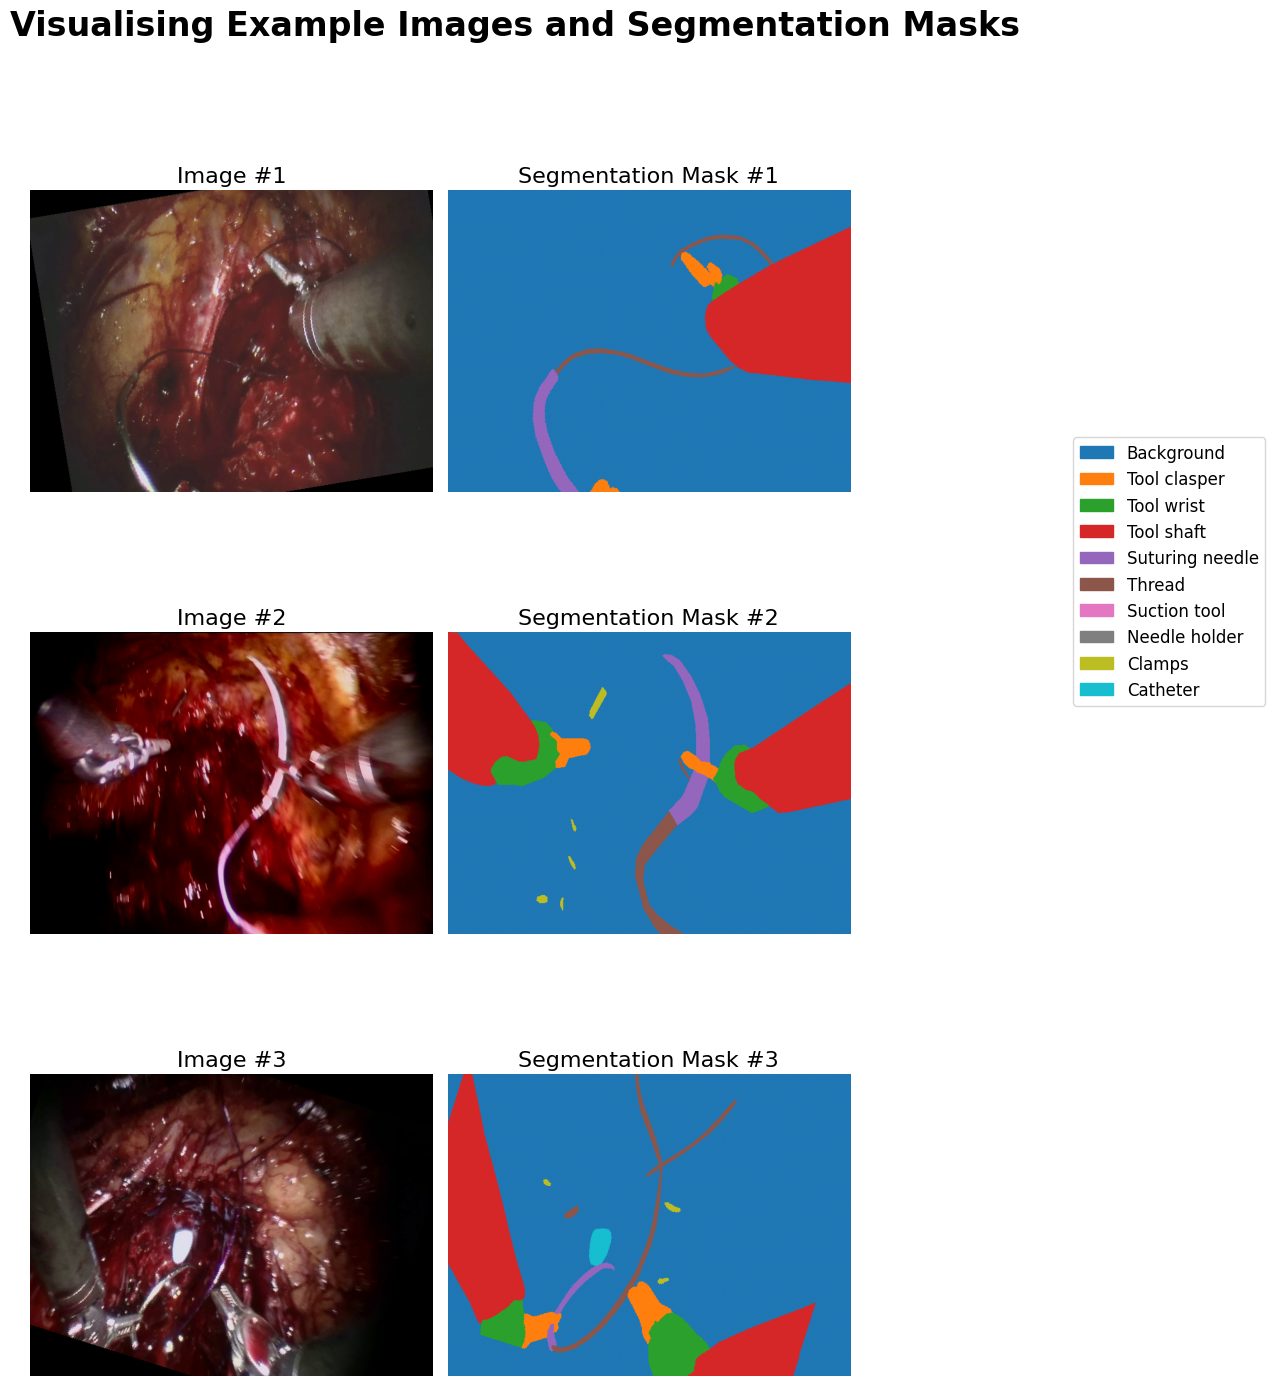

In [10]:
def visualise_from_generator(generator, num_examples=3):
    """Visualises images and masks from a data generator."""
    # Get a colormap for the segmentation mask
    colours = plt.get_cmap('tab10', NUM_CLASSES)
    custom_cmap = mcolors.ListedColormap(colours.colors)

    # Create the plot
    fig, ax = plt.subplots(num_examples, 2, figsize=(10, 5 * num_examples))
    fig.suptitle('Visualising Example Images and Segmentation Masks', fontsize=24, fontweight='bold')

    # Get a single batch from the generator
    sample_image_batch, sample_mask_batch = generator[0] # Get the first batch

    for i in range(num_examples):
        image = sample_image_batch[i]
        mask = sample_mask_batch[i]
        ax[i, 0].imshow(image)
        ax[i, 0].set_title(f'Image #{i+1}', fontsize=16)
        ax[i, 1].imshow(mask, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        ax[i, 1].set_title(f'Segmentation Mask #{i+1}', fontsize=16)

    # Add a legend to the figure
    legend_patches = [mpatches.Patch(color=colours.colors[i], label=class_names[i]) for i in range(NUM_CLASSES)]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.7), loc='upper left', fontsize=12)

    # Clean up the plot
    for axis in ax.flat:
        axis.axis('off')

    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for the legend
    plt.show()

visualise_from_generator(train_generator)

## 6. Model Architecture (U-Net with Pre-trained Encoder)

This section defines the model architecture. A U-Net model is used, which is a powerful model for biomedical image segmentation. To improve performance and training speed, the standard U-Net encoder is replaced with a pre-trained `EfficientNetB4` model, leveraging features learned from the ImageNet dataset.

### Encoder (Pre-trained EfficientNetB4)

In [12]:
def pretrained_encoder(inputs):
    """
    Creates a pre-trained EfficientNetB4 encoder and extracts feature maps
    at different scales for the U-Net skip connections.
    """

    # include_top=False: Excludes the final classification layer.
    # weights='imagenet': Loads weights pre-trained on the ImageNet dataset.
    encoder = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)

    # # freezes weights for initial training
    # encoder.trainable = False

    # Capture the skip connections at different levels of the encoder
    # The layers below were chosen to match the downsampling rates of a typical U-Net
    skip_connections = [
        inputs, # f1 480x640
        encoder.get_layer('block2a_expand_activation').output, # f2 240x320
        encoder.get_layer('block3a_expand_activation').output, # f3 120x160
        encoder.get_layer('block4a_expand_activation').output, # f4 60x80
    ]

    # Bottleneck
    b1 = encoder.get_layer('block6a_expand_activation').output # 30X40

    return b1, skip_connections

### Decoder

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    """ Adds 2 convolutional layers with Batch Normalisation and ReLU activation."""

    x = input_tensor
    for i in range(2):
      x = tf.keras.layers.Conv2D(filters=n_filters,
                                kernel_size=(kernel_size, kernel_size),
                                kernel_initializer='he_normal',
                                padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation('relu')(x)

    return x

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=2, dropout=0.3):
  """ Defines one upsampling block of the decoder. """
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c

def decoder(inputs, convs, output_channels):
  """ Defines the complete decoder (upsampling path) of the U-Net. """

  f1, f2, f3, f4 = convs

  # Upsampling block 1: from 1024 to 512 filters
  c6 = decoder_block(inputs, f4, n_filters=512)
  # Upsampling block 2: from 512 to 256 filters
  c7 = decoder_block(c6, f3, n_filters=256)
  # Upsampling block 3: from 256 to 128 filters
  c8 = decoder_block(c7, f2, n_filters=128)
  # Upsampling block 4: from 128 to 64 filters
  c9 = decoder_block(c8, f1, n_filters=64)

  # Final output layer
  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Full Model Assembly

In [15]:
def unet_pretrained(input_shape, output_channels):
  """ Defines a pre-trained version of the U-Net model by connecting the
  pre-trained EfficientNetB4 encoder and decoder."""

  inputs = tf.keras.layers.Input(shape=input_shape)
  encoder_output, convs = pretrained_encoder(inputs)
  outputs = decoder(encoder_output, convs, output_channels=output_channels)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

# Instantiate the model
model = unet_pretrained(input_shape, NUM_CLASSES)

# See the resulting model architecture
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 480, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 480, 640,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 480, 640,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 480, 640,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 481, 641,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 240, 320,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 240, 320,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 240, 320,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 240, 320,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 240, 320,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 240, 320,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 240, 320,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 240, 320,  │      1,152 │ block1a_se_excit

 Total params: 18,250,417 (69.62 MB)

 Trainable params: 18,195,994 (69.41 MB)

 Non-trainable params: 54,423 (212.59 KB)

## 7. Training the Model

This section defines the loss function and compiles the model.

* **Loss Function:** we use a combined **loss of Sparse Categorical Cross-entropy** and **Dice Loss**. This is a common strategy in segmentation tasks to balance pixel-wise accuracy with the overlap of segmented regions, which is particularly helpful for imbalanced classes.

* **Metric:** we use **MeanIoU (Mean Intersection over Union)**, which provides a meaningful measure of how well the predicted segmentation masks overlap with the ground-truth masks.

* **Callbacks:** Several callbacks are used to improve the training process, including `ModelCheckpoint` to save the best model, `EarlyStopping` to prevent overfitting, and `ReduceLROnPlateau` to adjust the learning rate.

### History Logger Helper Function

In [16]:
class HistoryLogger(Callback):
    """
    A Keras callback that robustly logs the training history to a CSV file
    at the end of each epoch.
    """
    def __init__(self, filename='live_training_history.csv'):
        super().__init__()
        self.filename = filename
        self.is_first_epoch = True

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # On the first epoch, open in 'write' mode and create the header
        if self.is_first_epoch:
            mode = 'w'
            header = ['epoch'] + list(logs.keys())
        # On subsequent epochs, open in 'append' mode
        else:
            mode = 'a'
            header = None # No need to write header again

        with open(self.filename, mode, newline='') as f:
            writer = csv.writer(f)
            if self.is_first_epoch:
                writer.writerow(header)

            # Write the data row
            row = [epoch + 1] + list(logs.values())
            writer.writerow(row)

        # Ensure we only write the header once
        self.is_first_epoch = False

### Loss function

In [17]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice loss, a measure of overlap between masks."""
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_pred_f = tf.cast(y_pred, tf.float32)

    # Flatten all dimensions except the class dimension
    y_true_f_flat = tf.keras.layers.Flatten()(y_true_one_hot)
    y_pred_f_flat = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true_f_flat * y_pred_f_flat, axis=-1)
    union = tf.reduce_sum(y_true_f_flat, axis=-1) + tf.reduce_sum(y_pred_f_flat, axis=-1)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff

def combined_loss(y_true, y_pred):
    """Combines Sparse Categorical Cross-entropy and Dice Loss."""
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    cross_entropy_mean = tf.reduce_mean(cross_entropy, axis=[1, 2])
    dice = dice_loss(y_true, y_pred)
    return (0.5 * cross_entropy_mean) + (0.5 * dice)

### Compile and Train

In [20]:
# --- Compile the Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[MeanIoU(num_classes=NUM_CLASSES, sparse_y_true=True, sparse_y_pred=False)]
)

# --- Define Callbacks ---
os.makedirs(MODEL_DIR, exist_ok=True)
model_checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_mean_io_u', mode='max', save_best_only=True, verbose=1)
early_stopper = EarlyStopping(patience=8, monitor='val_mean_io_u', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_mean_io_u', mode='max', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
history_logger = HistoryLogger(HISTORY_SAVE_PATH)

# --- Start Training ---
N_EPOCHS = 50

model_history = model.fit(
    train_generator,
    epochs=N_EPOCHS,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, early_stopper, reduce_lr, history_logger]
)

Epoch 1/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6464 - mean_io_u: 0.1803
Epoch 1: val_mean_io_u improved from -inf to 0.32165, saving model to /content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/models/unet_efficientnetb4_best.keras
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1737s 1s/step - loss: 0.6462 - mean_io_u: 0.1804 - val_loss: 0.2519 - val_mean_io_u: 0.3217 - learning_rate: 1.0000e-04
Epoch 2/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1514 - mean_io_u: 0.4033
Epoch 2: val_mean_io_u improved from 0.32165 to 0.46099, saving model to /content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/models/unet_efficientnetb4_best.keras
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1528s 1s/step - loss: 0.1514 - mean_io_u: 0.4033 - val_loss: 0.1770 - val_mean_io_u: 0.4610 - learning_rate: 1.0000e-04
Epoch 3/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1126 - mean_io_u: 0.5265
Epoch 3: val_mean_io_u improved from 0.46099 to 0.55228, saving model to 

KeyboardInterrupt: 